In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Question 1

In [2]:
TOP_UNIV_BASE = "https://www.topuniversities.com"
TOP_UNIV_WEBSITE = "https://www.topuniversities.com/university-rankings/world-university-rankings/2018"
# This is the file containing the general informations about university in the topuniversities website.
TOP_UNIV_DATA_INDICATOR = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt"

In [3]:
# We get the file containing information about the universities
data_indicator = requests.get(TOP_UNIV_DATA_INDICATOR)

indicator_data = json.loads(data_indicator.text)

In [4]:
# Utility function to parse integers
def parse_int(string):
    tmp = string.replace(',', '')
    return int(tmp)

# For each university entry in the indicator file, we get the detail of the university.
# This method returns a list with every information requested
def get_university_info_from_indicator(raw_university):
    overview_soup = BeautifulSoup(raw_university["uni"], 'html.parser')    
    
    name = overview_soup.a.text
    rank = raw_university["overall_rank"]
    region = raw_university["region"]
    country = raw_university["location"]
    
    # Append
    details_request = requests.get(TOP_UNIV_BASE + "/" +  overview_soup.a.attrs['href'])
    details_soup = BeautifulSoup(details_request.text, 'html.parser')
    
    try:      
        total_staff = parse_int(details_soup.find("div", {"class": "total faculty"}).find("div", {"class" : "number"}).text)
        inter_staff = parse_int(details_soup.find("div", {"class": "inter faculty"}).find("div", {"class" : "number"}).text)
        total_students = parse_int(details_soup.find("div", {"class": "total student"}).find("div", {"class": "number"}).text)
        inter_students = parse_int(details_soup.find("div", {"class": "total inter"}).find("div", {"class": "number"}).text)
    except:
        total_staff = np.nan
        inter_staff = np.nan
        total_students = np.nan
        inter_students = np.nan
        
    return [name, rank, country, region, inter_staff, total_staff, inter_students, total_students]


In [6]:
# The main loop, for each university in the indicator file.
univ_list = []

for i, raw_university in enumerate(indicator_data["data"][0:200]):
    print(i, end="\r")
    univ_list.append(get_university_info_from_indicator(raw_university))
    
        
top_univ_df = pd.DataFrame(univ_list, columns=["name", "rank", "country", "region", "inter_staff", "total_staff", "inter_students", "total_students"])

In [7]:
top_univ_df

,name,rank,country,region,inter_staff,total_staff,inter_students,total_students
0,Massachusetts Institute of Technology (MIT),1,United States,North America,1679.0,2982.0,3717.0,11067.0
1,Stanford University,2,United States,North America,2042.0,4285.0,3611.0,15878.0
2,Harvard University,3,United States,North America,1311.0,4350.0,5266.0,22429.0
3,California Institute of Technology (Caltech),4,United States,North America,350.0,953.0,647.0,2255.0
4,University of Cambridge,5,United Kingdom,Europe,2278.0,5490.0,6699.0,18770.0
5,University of Oxford,6,United Kingdom,Europe,2964.0,6750.0,7353.0,19720.0
6,UCL (University College London),7,United Kingdom,Europe,2554.0,6345.0,14854.0,31080.0
7,Imperial College London,8,United Kingdom,Europe,2071.0,3930.0,8746.0,16090.0
8,University of Chicago,9,United States,North America,635.0,2449.0,3379.0,13557.0
9,ETH Zurich - Swiss Federal Institute of Techno...,10,Switzerland,Europe,1886.0,2477.0,7563.0,19815.0


In [8]:
top_univ_df.to_csv("top_univ_df.csv")

In [3]:
top_univ_df = pd.read_csv("top_univ_df.csv", index_col=False, usecols=range(1, 9))

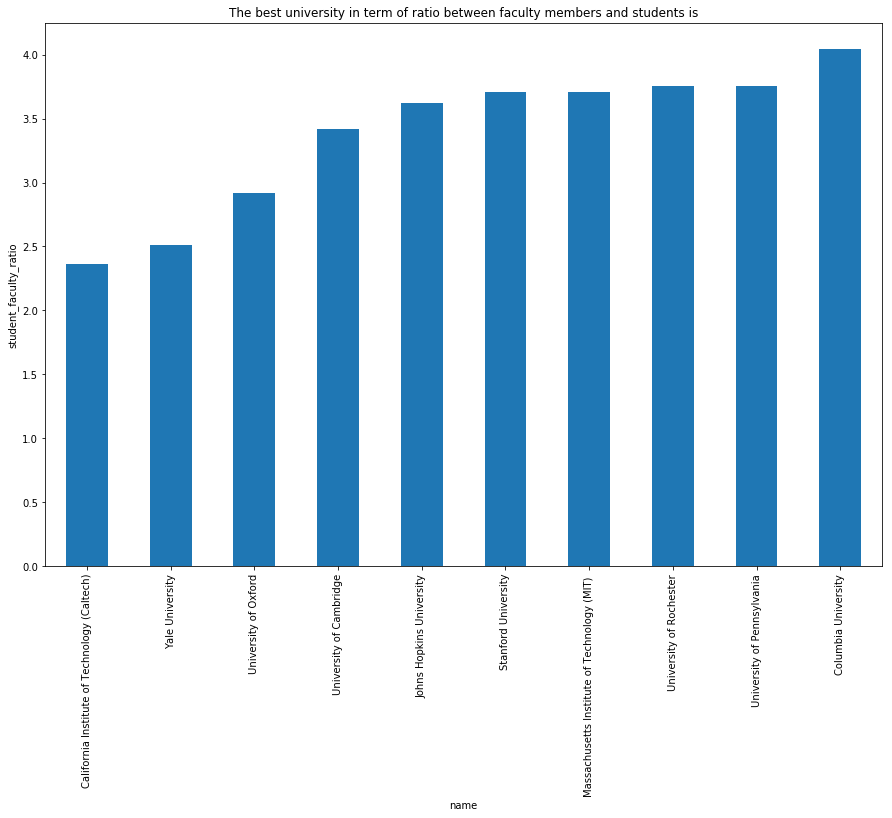

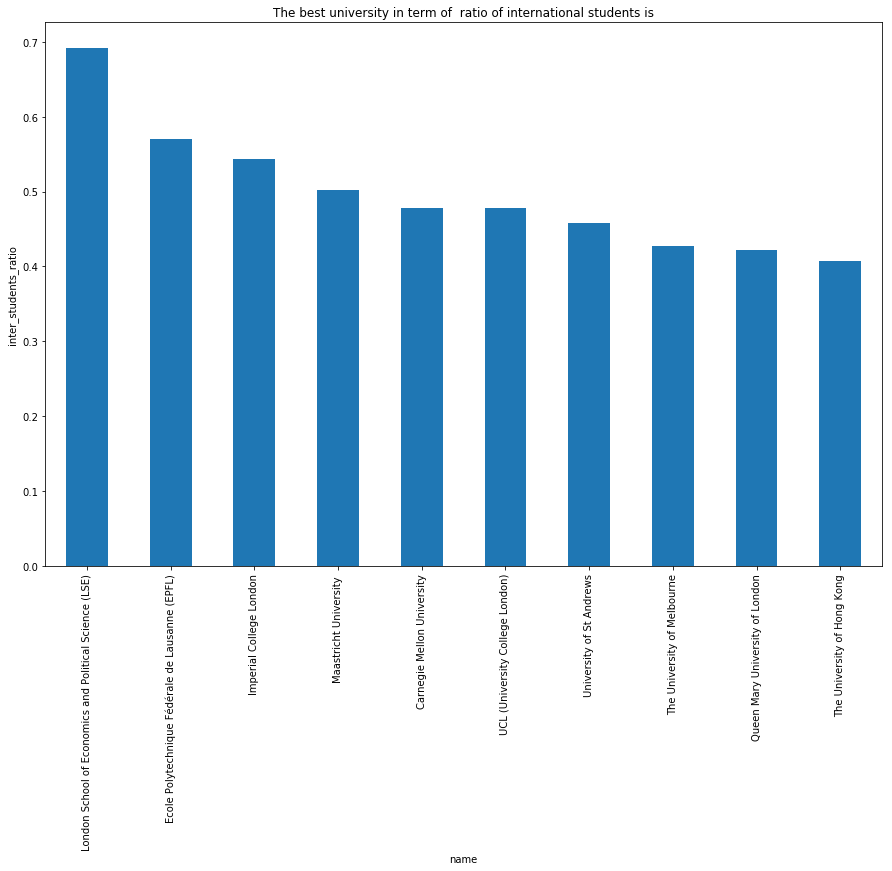

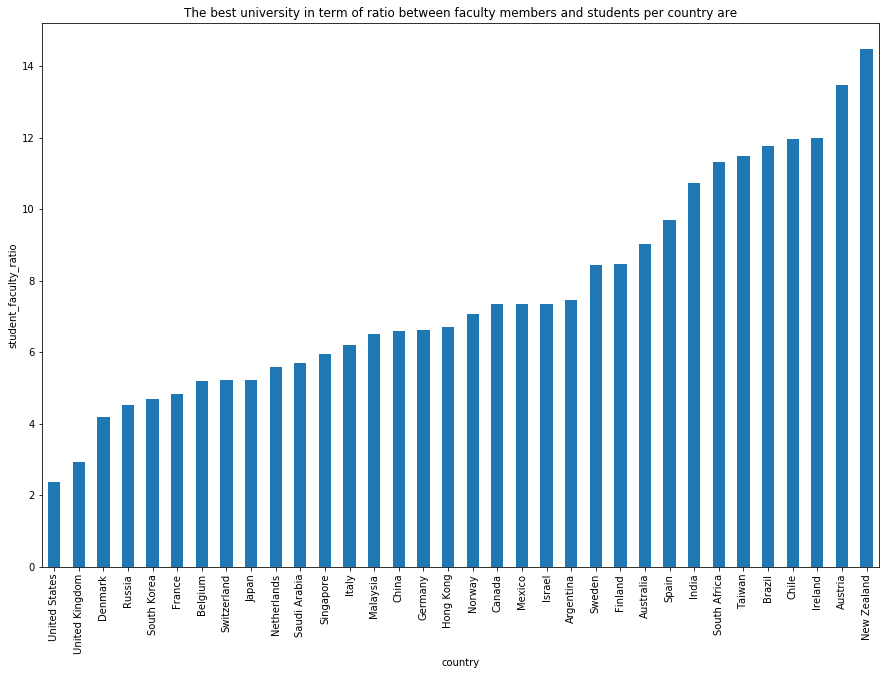

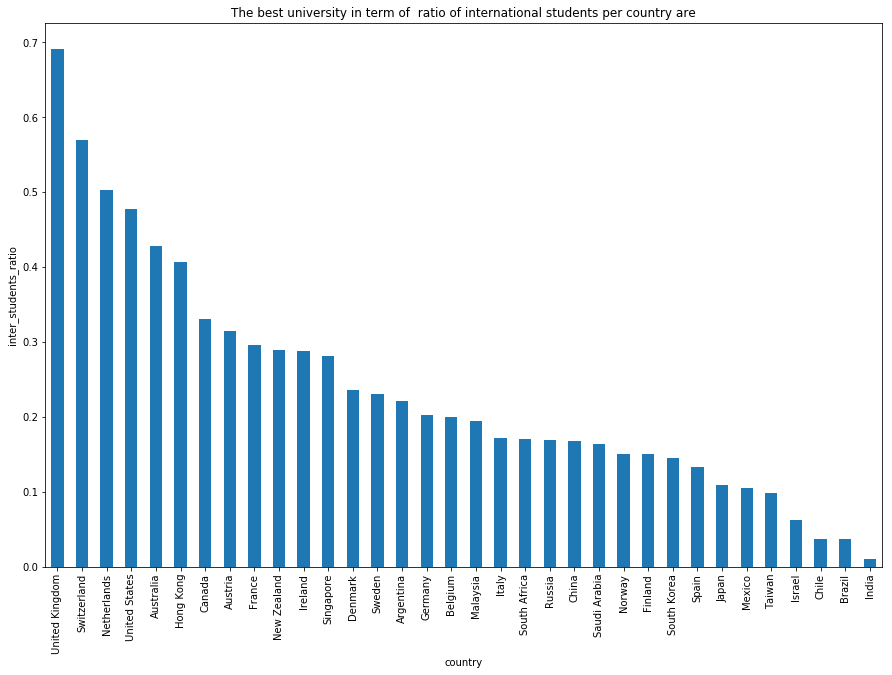

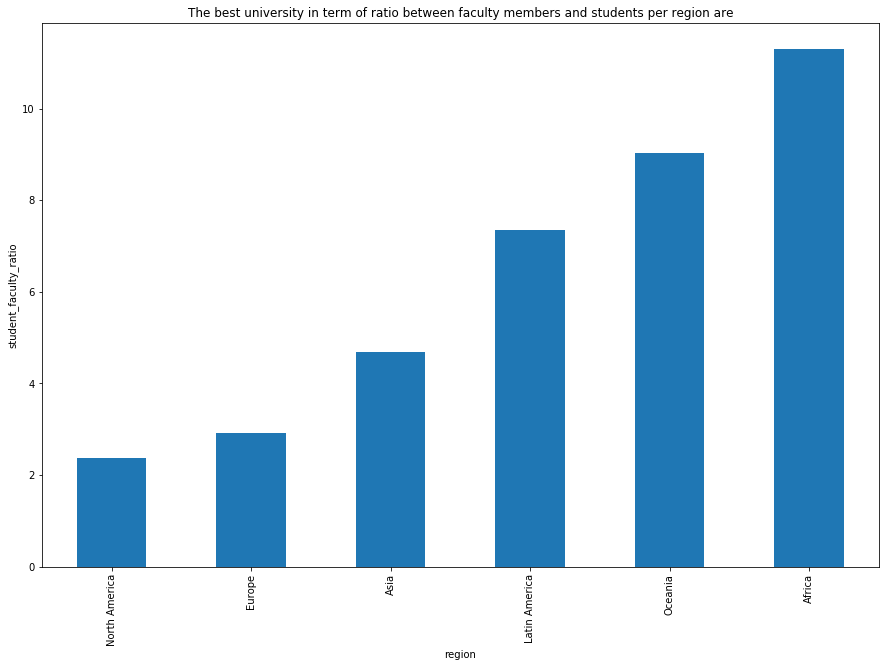

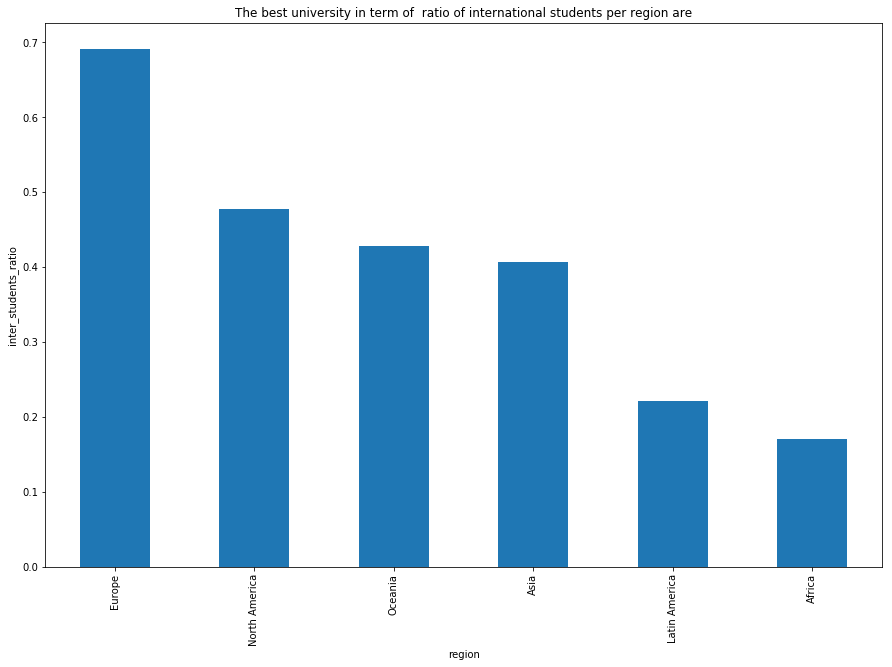

In [27]:
def print_best_university_with_ratio(df, ratio_name, ascending, quantity, title): 
    sorted_df = df.sort_values(ratio_name, ascending=ascending)
    sorted_df.set_index("name").loc[:, ratio_name].head(quantity).plot(kind="bar", title=title, figsize=(15, 10))
    plt.ylabel(ratio_name)
    plt.show()
        
def print_best_university_with_ratio_grouped(df_grouped, group_name, ratio_name, take_min, title):
    lambda_min = lambda x: x[x[ratio_name] == x[ratio_name].min()]
    lambda_max = lambda x: x[x[ratio_name] == x[ratio_name].max()]
    
    best_by_group = df_grouped.apply(lambda_min if take_min else lambda_max).reset_index(1).drop("level_1", 1).sort_values(ratio_name, ascending=take_min)
    best_by_group.loc[:, ratio_name].plot(kind="bar", title=title, figsize=(15, 10), )
    plt.ylabel(ratio_name)
    plt.show()

def append_column_to_dataframe(dataframe, column, column_name):
    output_df = dataframe.copy()
    output_df.loc[:, column_name] = column
    return output_df

members_to_studends_ratio = top_univ_df.total_students / top_univ_df.total_staff
top_univ_df_with_ratio_a = append_column_to_dataframe(top_univ_df, members_to_studends_ratio, "student_faculty_ratio")

inter_students_ratio = top_univ_df.inter_students / top_univ_df.total_students
top_univ_df_with_ratios = append_column_to_dataframe(top_univ_df_with_ratio_a, inter_students_ratio, "inter_students_ratio")


print("")
print_best_university_with_ratio(top_univ_df_with_ratios, "student_faculty_ratio", True, 10, "The best university in term of ratio between faculty members and students is")
print("\n\n")
print_best_university_with_ratio(top_univ_df_with_ratios, "inter_students_ratio", False, 10, "The best university in term of  ratio of international students is")

top_univ_df_with_ratios_by_country = top_univ_df_with_ratios.groupby("country") 
top_univ_df_with_ratios_by_region = top_univ_df_with_ratios.groupby("region") 

print("\n\n")
print_best_university_with_ratio_grouped(top_univ_df_with_ratios_by_country, "country", "student_faculty_ratio", True, "The best university in term of ratio between faculty members and students per country are")
print("\n\n")
print_best_university_with_ratio_grouped(top_univ_df_with_ratios_by_country, "country", "inter_students_ratio", False, "The best university in term of  ratio of international students per country are")

print("\n\n")
print_best_university_with_ratio_grouped(top_univ_df_with_ratios_by_region, "region", "student_faculty_ratio", True, "The best university in term of ratio between faculty members and students per region are")
print("\n\n")
print_best_university_with_ratio_grouped(top_univ_df_with_ratios_by_region, "region", "inter_students_ratio", False, "The best university in term of  ratio of international students per region are")


## Question 2
Since timeshighereducation.com doesn't categorize universities by region like topuniversities.com does, we have to find the region based on the country. To do that, we create a dictionnary of country-region pair from the previous dataset.

In [9]:
TIMES_HIGHER_DATA = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"

# Loads JSON files containing universities data
th_data = json.loads(requests.get(TIMES_HIGHER_DATA).text)

In [10]:
# Creates a dictionnary of country-region pairs from the topuniversities.com dataset
map_country_region = top_univ_df[['country', 'region']].groupby('country').agg(lambda x:x.value_counts().index[0])
map_country_region = map_country_region.T.to_dict('list')

# Add missing value
map_country_region['Luxembourg'] = ['Europe']

In [11]:
def parse_percentage(string):
    """Parse a string representing a percentage as a float"""
    return float(string.strip('%'))/100

def th_get_university_info(raw_university):
    """Extract the relevent university info from the raw university data"""
    
    name = raw_university["aliases"]
    rank = raw_university["rank"].strip('=')
    country = raw_university["location"]
    if country=='Russian Federation':
        country = 'Russia'
        
    region = map_country_region[country][0]
    
    total_students = parse_int(raw_university["stats_number_students"])
    inter_students_ratio = parse_percentage(raw_university["stats_pc_intl_students"])
    student_faculty_ratio = (float)(raw_university["stats_student_staff_ratio"])
    
    
    return [name, rank, country, region, total_students, inter_students_ratio, student_faculty_ratio]

In [12]:
th_univ_list = []

# Extract data for all universities
for i, raw_university in enumerate(th_data["data"][0:200]):
    print(i, end="\r")
    th_univ_list.append(th_get_university_info(raw_university))
    
        
times_higher_df = pd.DataFrame(th_univ_list, columns=["name", "rank", "country", "region", "total_students", "inter_students_ratio", "student_faculty_ratio"])
times_higher_df.to_csv("times_higher_df.csv")
times_higher_df

,name,rank,country,region,total_students,inter_students_ratio,student_faculty_ratio
0,University of Oxford,1,United Kingdom,Europe,20409,0.38,11.2
1,University of Cambridge,2,United Kingdom,Europe,18389,0.35,10.9
2,California Institute of Technology caltech,3,United States,North America,2209,0.27,6.5
3,Stanford University,3,United States,North America,15845,0.22,7.5
4,Massachusetts Institute of Technology,5,United States,North America,11177,0.34,8.7
5,Harvard University,6,United States,North America,20326,0.26,8.9
6,Princeton University,7,United States,North America,7955,0.24,8.3
7,Imperial College London,8,United Kingdom,Europe,15857,0.55,11.4
8,University of Chicago,9,United States,North America,13525,0.25,6.2
9,ETH Zurich – Swiss Federal Institute of Techno...,10,Switzerland,Europe,19233,0.38,14.6


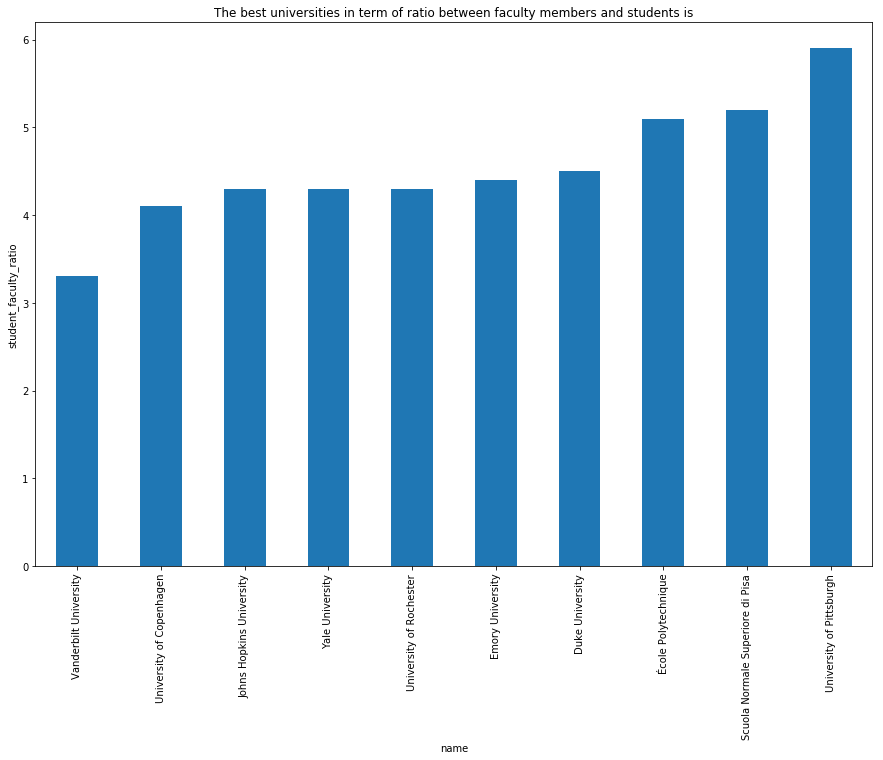

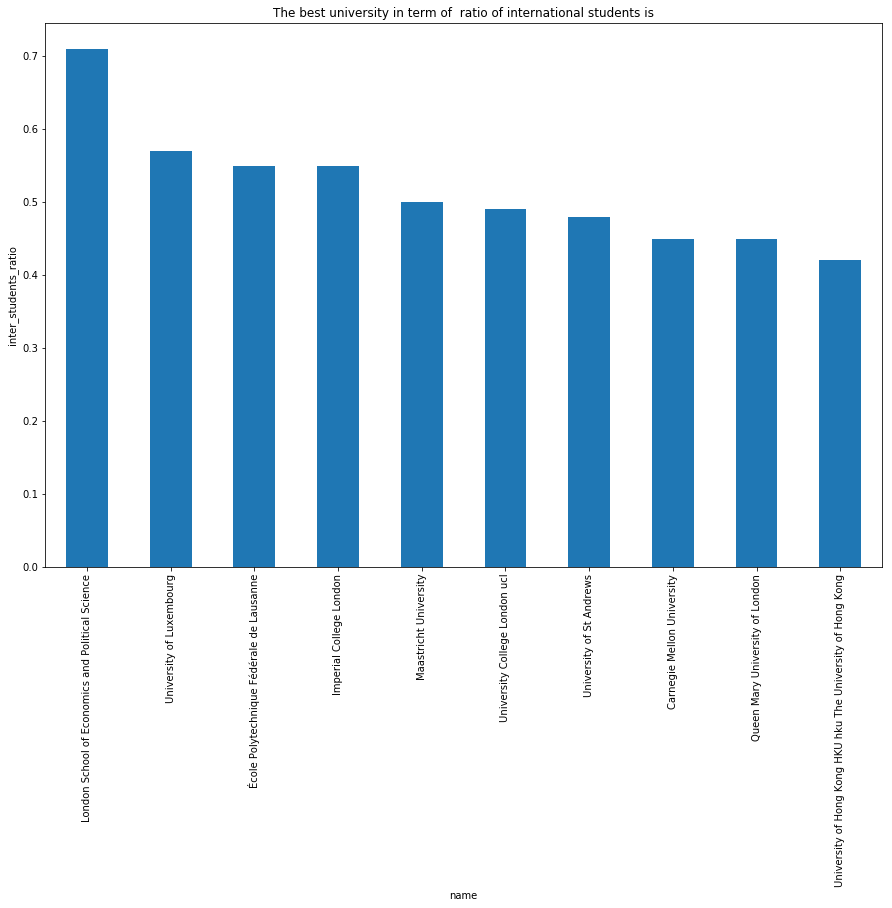

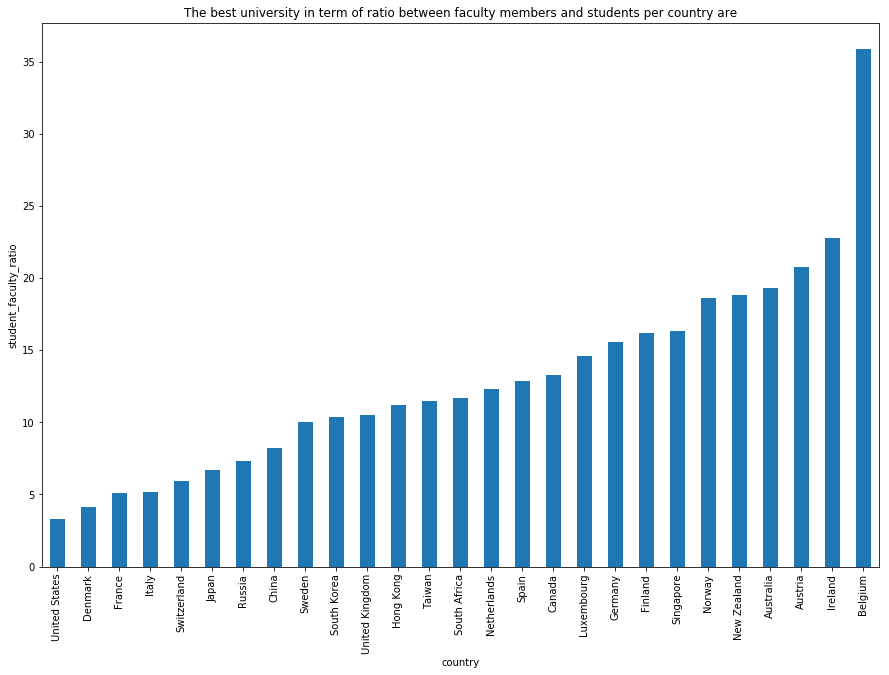

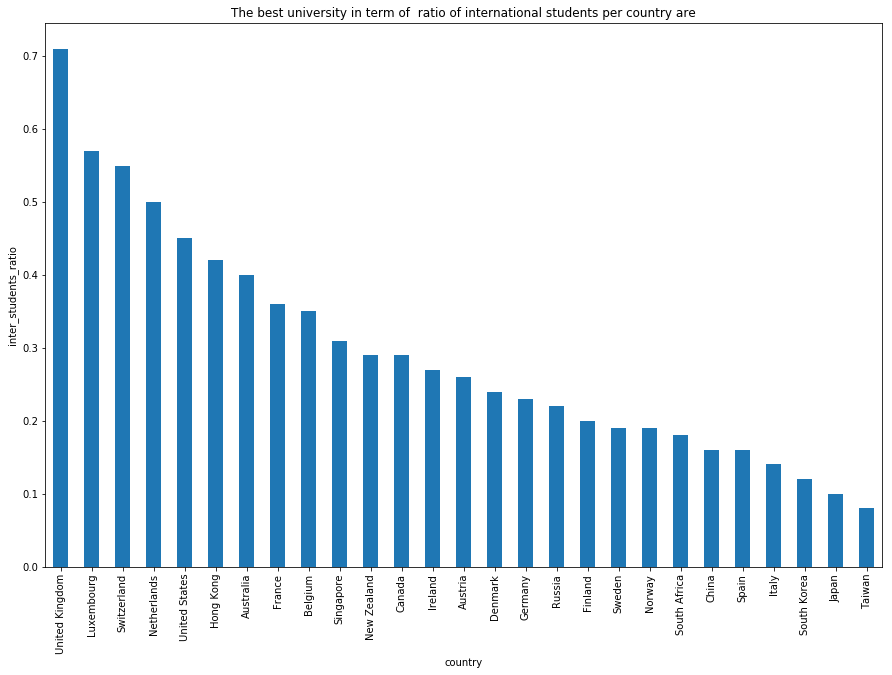

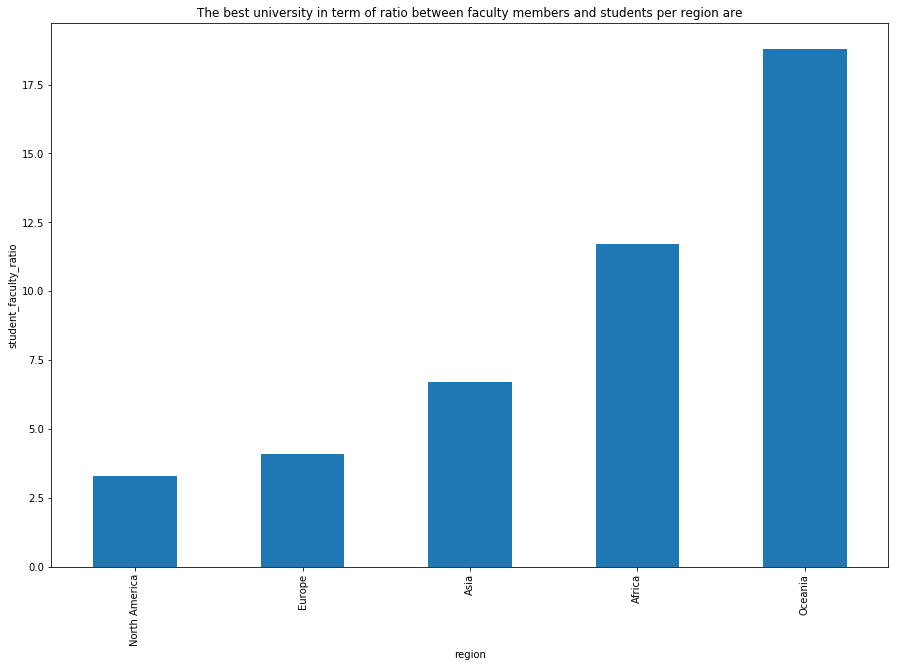

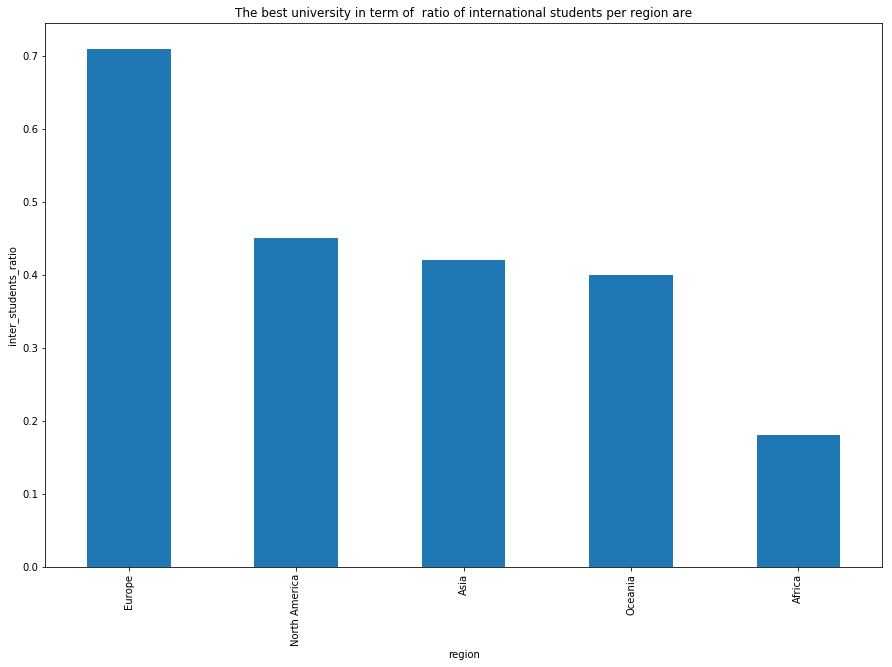

In [15]:
print_best_university_with_ratio(times_higher_df, "student_faculty_ratio", True, 10, "The best universities in term of ratio between faculty members and students is")
print("\n\n")
print_best_university_with_ratio(times_higher_df, "inter_students_ratio", False, 10, "The best university in term of  ratio of international students is")

times_higher_df_country = times_higher_df.groupby("country") 
times_higher_df_region = times_higher_df.groupby("region") 

print("\n\n")
print_best_university_with_ratio_grouped(times_higher_df_country, "country", "student_faculty_ratio", True, "The best university in term of ratio between faculty members and students per country are")
print("\n\n")
print_best_university_with_ratio_grouped(times_higher_df_country, "country", "inter_students_ratio", False, "The best university in term of  ratio of international students per country are")

print("\n\n")
print_best_university_with_ratio_grouped(times_higher_df_region, "region", "student_faculty_ratio", True, "The best university in term of ratio between faculty members and students per region are")
print("\n\n")
print_best_university_with_ratio_grouped(times_higher_df_region, "region", "inter_students_ratio", False, "The best university in term of  ratio of international students per region are")


## Question 3

In [4]:
times_higher_df = pd.read_csv("times_higher_df.csv", index_col=False, usecols=range(1, 8))

In [54]:
from difflib import SequenceMatcher

def str_simil(a, b):
    return SequenceMatcher(None, a, b).ratio()

uni_1 = 'California Institute of Technology caltech'
uni_2 = 'California Institute of Technology (Caltech)'
#str_corr(uni_1, uni_2)

def match_universities(df1, df2):
    """Match the universities of the 2 dataframes based on the name and country.
       Returns a list of tuples corresponding to the indices of the 2 matched universities"""
    
    df1 = df1.copy()
    df2 = df2.copy()
    
    # Remove common words (e.g. University) from all names. This would add irrelevant similarity if kept.
    df1.loc[:,'name'] = df1['name'].apply(lambda n: n.replace('University', ''))
    df2.loc[:,'name'] = df2['name'].apply(lambda n: n.replace('University', ''))
    
    matches = []
    already_matched = []
    for i1, row1 in df1.iterrows():
        max_simil = 0
        indices = (None, None)
        for i2, row2 in df2.iterrows():
            if(row1['country'] == row2['country']) and i2 not in already_matched:
                # Compute string similarity between the two names
                simil = str_simil(row1['name'], row2['name'])
                #print([row1['name'], row2['name'], max_simil])
                
                if simil > max_simil:
                    max_simil = simil
                    indices = (i1, i2)
        
        if max_simil >= 0.75:
            #print([top_univ_df.get_value(indices[0],'name'), times_higher_df.get_value(indices[1],'name'), max_simil])
            matches.append(indices)
            already_matched.append(indices[1])
        else:
            if indices[0] != None and indices[1] != None: 
                pass
                #print([top_univ_df.get_value(indices[0],'name'), times_higher_df.get_value(indices[1],'name'), max_simil])
            
    return matches

def rename_matching_universities(df1, df2, matches):
    """Rename universities of the second dataframe to have the same name as their match in the first dataframe"""
    for match in matches:
        name = df1.get_value(match[0],'name')
        df2.at[match[1], 'name'] = name

    return (df1, df2)

In [63]:
df1 = top_univ_df_with_ratios.copy()
df2 = times_higher_df.copy()
matches = match_universities(df1, df2)

df1, df2 = rename_matching_universities(df1, df2, matches)

In [65]:
merged_df = df1[["name", "rank", "country", "region", "student_faculty_ratio", "inter_students_ratio"]].merge(
    df2[["name", "rank", "student_faculty_ratio", "inter_students_ratio"]], how="inner", on="name")

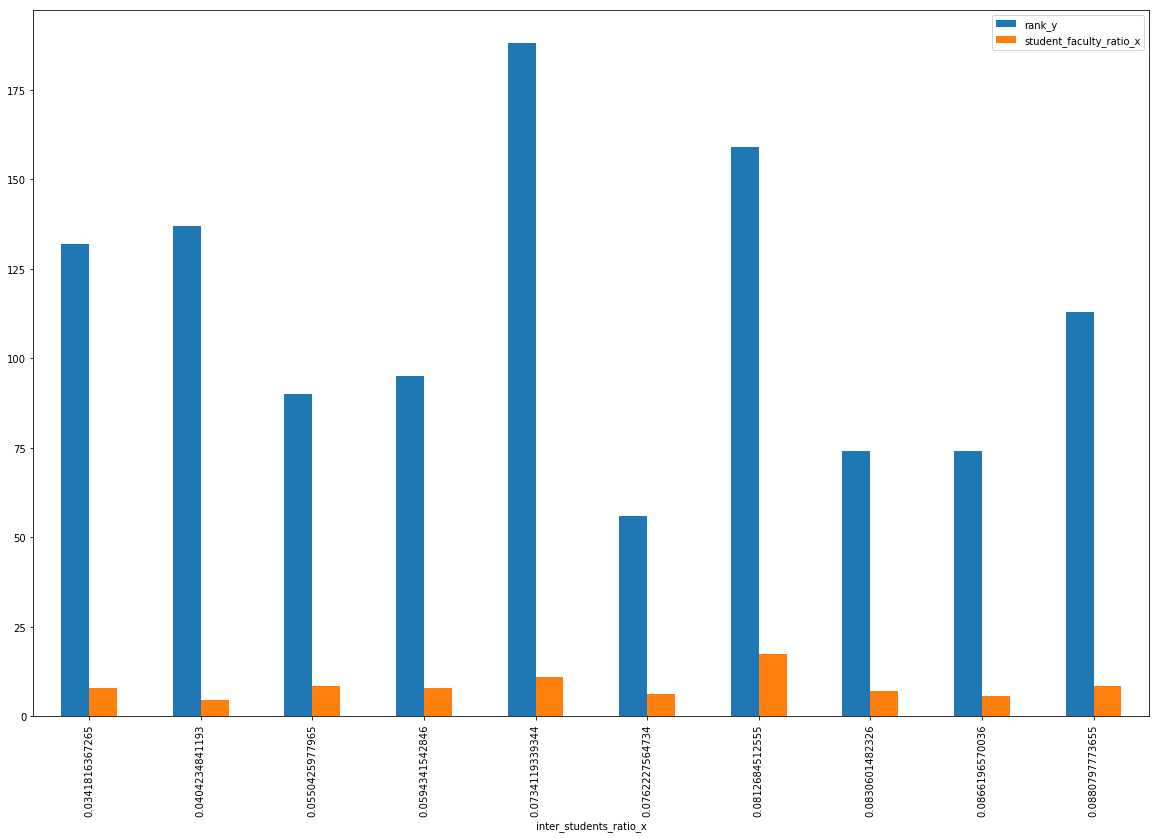

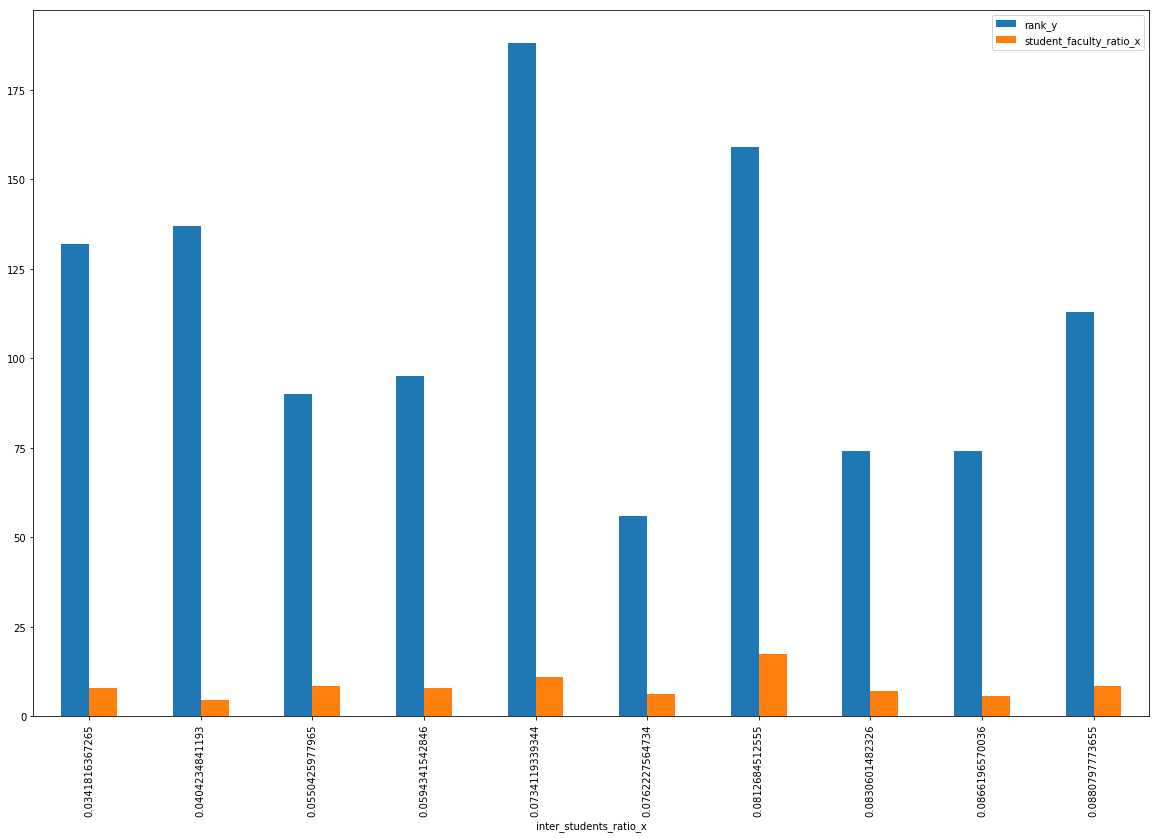

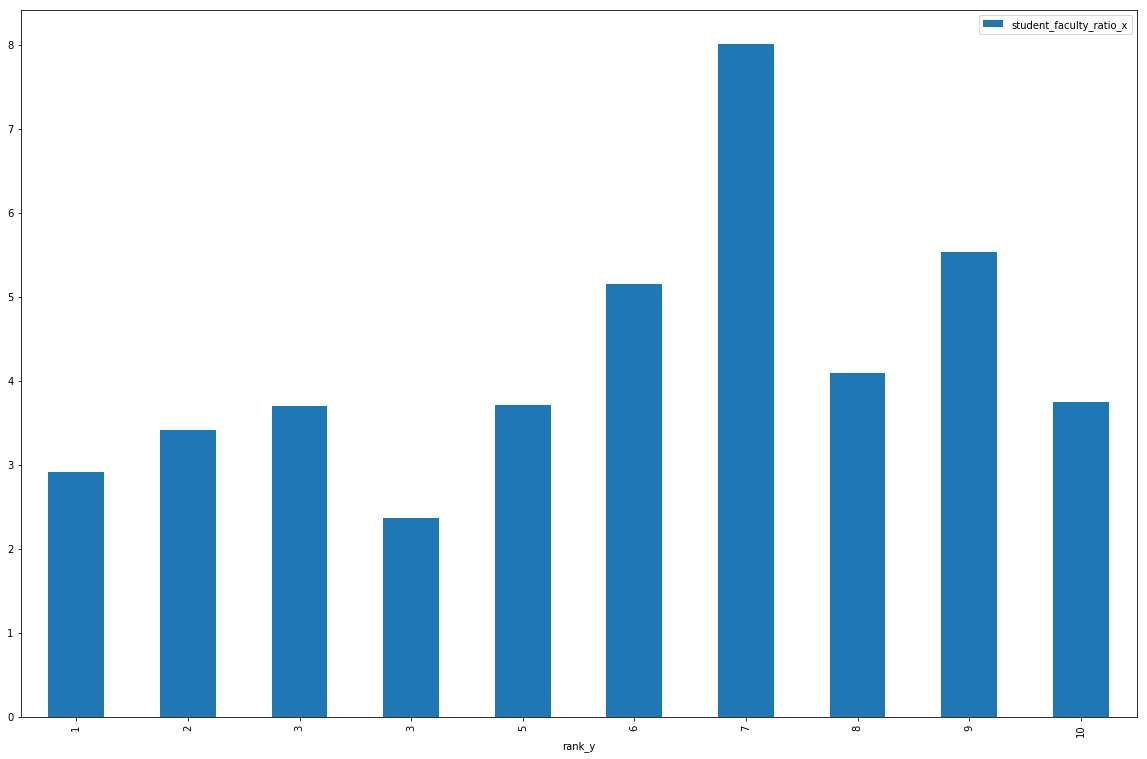

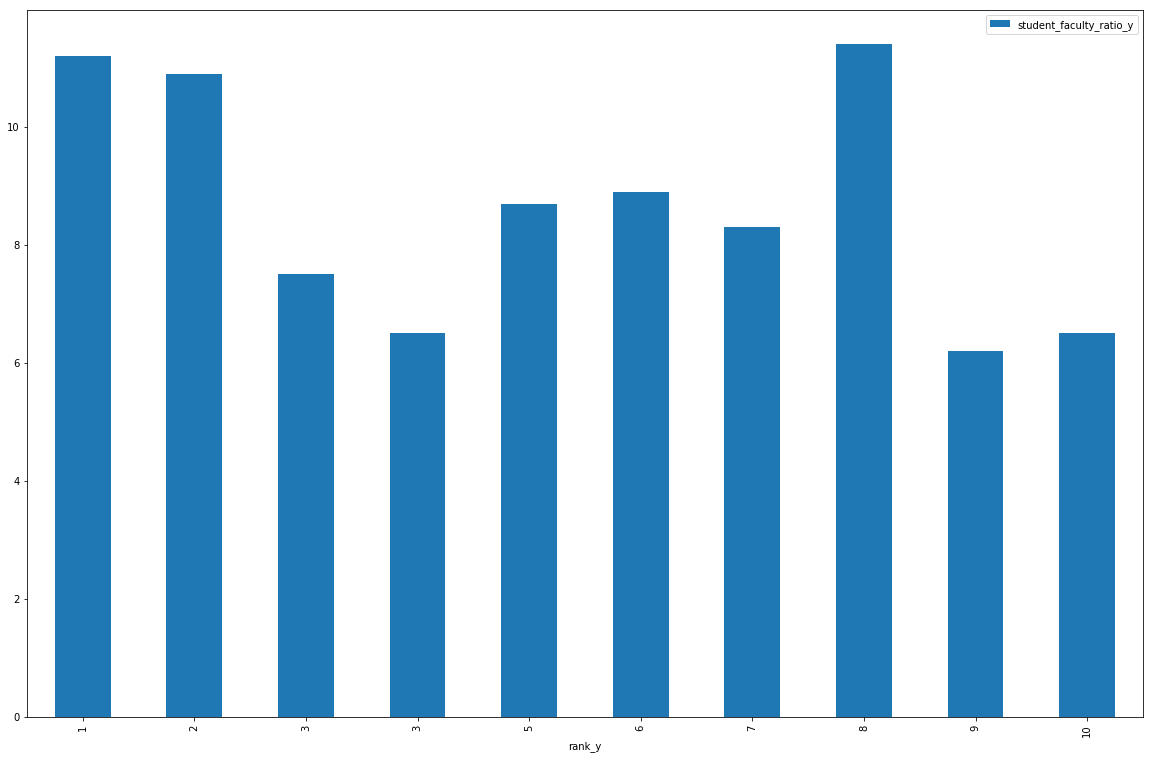

In [91]:
merged_df.sort_values("inter_students_ratio_x", ascending=True)[["inter_students_ratio_x", "rank_y", "student_faculty_ratio_x"]].head(10).set_index("inter_students_ratio_x").plot.bar(figsize=(20,13))
plt.show()
merged_df.sort_values("inter_students_ratio_x", ascending=True)[["inter_students_ratio_x", "rank_y", "student_faculty_ratio_x"]].head(10).set_index("inter_students_ratio_x").plot.bar(figsize=(20,13))
plt.show()
merged_df.sort_values("rank_y", ascending=True)[["rank_y", "student_faculty_ratio_x"]].head(10).set_index("rank_y").plot.bar(figsize=(20,13))
plt.show()
merged_df.sort_values("rank_y", ascending=True)[["rank_y", "student_faculty_ratio_y"]].head(10).set_index("rank_y").plot.bar(figsize=(20,13))
plt.show()